In [1]:
# env
!which python

/home/david/mambaforge/envs/bmcp/bin/python


# Bayesian Methods for Hackers - Chapter 1 Modified Text Message Model
+ setup for 2 alternative sets of prior distributions

In [2]:
import os
import math
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import scipy.stats as stats
from plotnine import *
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az

%matplotlib inline
%load_ext dotenv
%dotenv
# %load_ext autoreload
# %autoreload 2
theme_set(theme_bw())
pd.set_option('display.max_columns', 500)

SEED = 919

PROJECT_DIR = Path(os.environ['PROJECT_DIR'])
DATA_DIR = PROJECT_DIR / 'data'
DATA_DIR

PosixPath('/media/david/T7/code/bmcp/bmcp-notes/data')

+ 1.0 Create fake data
    + 1.1 Setup base distributions
    + 1.2 View fake data parameters - distributions & parameters
    + 1.3 Sample from fake data distributions to create base dataset
    + 1.4 Add noise
    + 1.5 Plot Data
+ 2.0 Prepare to Model
    + 2.1 Imaginary Context
    + 2.2 Compare fit of poisson distributions to before and after change observed data
    + 2.3 make Point Estimates
+ 3.0 Model
    + 3.1 Setup Model
    + 3.2 Review distributions of Priors
    + 3.3 Model using just the priors
    + 3.4 Fit the data
+ 4.0 Review the model output
+ 5.0 Summary
    + 5.1 Underlying Structure
    + 5.2 Clean Data
    + 5.3 Noisy Data
    + 5.4 Point Estimates
    + 5.5 Prior Predictive
    + 5.6 Posteriors
    + 5.7 Predicted Data

# 1.0 Create Fake Data
+ Known:
    + First 30 days are stable
    + Somewhere between day 30 and day 40 there is a possible change in the distribution
    + 70 days of data
    + data can be modeled by poisson distribution
+ Unknown:
    + Initial distribution mean
    + later distribution mean
    + Exact day of distribution shift

In [3]:
np.random.seed(SEED)
lambda_1 = stats.randint.rvs(10, 18)
lambda_2 = stats.randint.rvs(15, 20)
stable_period = 30
change_window = 10
change_day = stats.randint.rvs(0, change_window)
total_days = 70

days_at_1 = stable_period + change_day
days_at_2 = total_days - (stable_period + change_day)

## 1.1 Setup Base Distributions

In [4]:
lambda_1_dist = pd.Series(stats.poisson.pmf(np.arange(40), lambda_1)).reset_index().assign(lambda_id=1).rename(columns={0: 'proba', 'index': 'k'})
lambda_2_dist = pd.Series(stats.poisson.pmf(np.arange(40), lambda_2)).reset_index().assign(lambda_id=2).rename(columns={0: 'proba', 'index': 'k'})
df_dists = pd.concat([lambda_1_dist, lambda_2_dist], axis=0).reset_index(drop=True)
df_dists.head()

,k,proba,lambda_id
0,0,0.000006,1
1,1,0.000074,1
2,2,0.000442,1
3,3,0.001770,1
4,4,0.005309,1


## 1.2 View fake data distributions & parameters

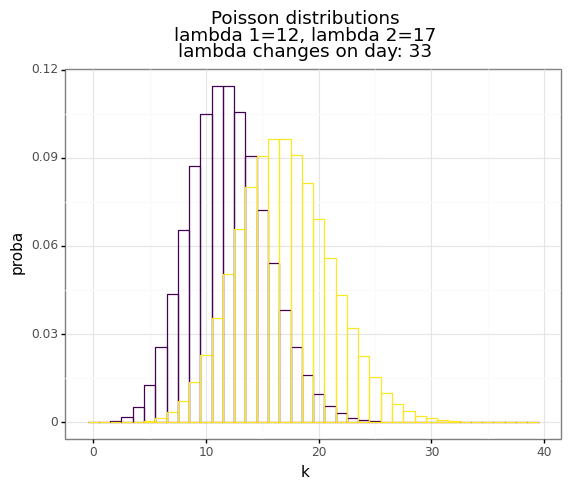

In [5]:
p = (ggplot(df_dists, aes(x='k', y='proba', colour='lambda_id')) +
     geom_col(position='dodge', alpha=0.5, width=1.0, fill="none") +
     theme(legend_position="none") +
     labs(title=f"Poisson distributions\nlambda 1={lambda_1}, lambda 2={lambda_2}\nlambda changes on day: {days_at_1}")
    )
p.draw();

## 1.3 Sample from distributions to create fake data

In [6]:
first = pd.DataFrame({'lambda_id': 1, 'n': range(0, days_at_1)})
second = pd.DataFrame({'lambda_id': 2, 'n': range(0, days_at_2)})
df_samples = pd.concat([first, second], axis=0).reset_index(drop=True)

In [7]:
np.random.seed(SEED)
samples_1 = stats.poisson.rvs(lambda_1, size=days_at_1)
samples_2 = stats.poisson.rvs(lambda_2, size=days_at_2)
df_samples['count'] = np.append(samples_1, samples_2)
df_samples = df_samples.reset_index().rename(columns={'index': 'day'})
df_samples.head()

,day,lambda_id,n,count
0,0,1,0,10
1,1,1,1,12
2,2,1,2,8
3,3,1,3,12
4,4,1,4,11


## 1.4 Add Noise
+ CHECK METHOD

In [8]:
np.random.seed(SEED)
# Not sure if this is correct
# https://stackoverflow.com/questions/19289470/adding-poisson-noise-to-an-image
df_samples['obs_count'] = stats.poisson.rvs(df_samples['count'].values)

## 1.5 Prepare data
+ Strip unneeded columns from dataset, so just left with the raw data

In [9]:
# Strip unneeded columns from dataset, so just left with the raw data
df_rawdata = df_samples.copy()
df_rawdata = df_samples[['day', 'obs_count']]
df_rawdata

,day,obs_count
0,0,8
1,1,12
2,2,6
3,3,12
4,4,8
...,...,...
65,65,21
66,66,10
67,67,13
68,68,20


In [10]:
df_samples

,day,lambda_id,n,count,obs_count
0,0,1,0,10,8
1,1,1,1,12,12
2,2,1,2,8,6
3,3,1,3,12,12
4,4,1,4,11,8
...,...,...,...,...,...
65,65,2,32,14,21
66,66,2,33,15,10
67,67,2,34,15,13
68,68,2,35,21,20


## 1.6 Plot faked Data

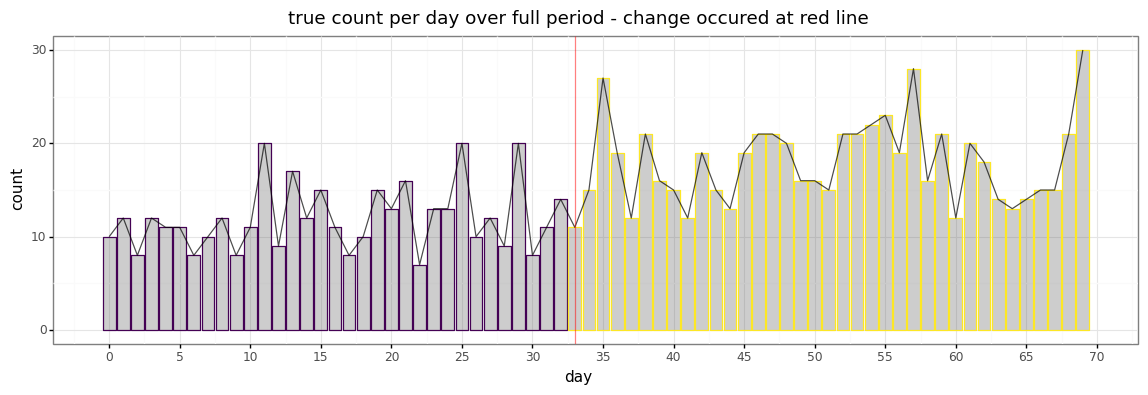

In [11]:
p = (ggplot(df_samples, aes(x='day', y='count', colour='lambda_id')) +
     geom_col(alpha=0.3) +
     geom_line(colour='black', alpha=0.7) +
     geom_vline(xintercept=stable_period + change_day, alpha=0.5, color='red') +
     scale_x_continuous(breaks=np.arange(0, total_days+1, 5)) +
     labs(title="true count per day over full period - change occured at red line") +
     theme(legend_position="none") +
     theme(figure_size=(14, 4)))
p.draw();

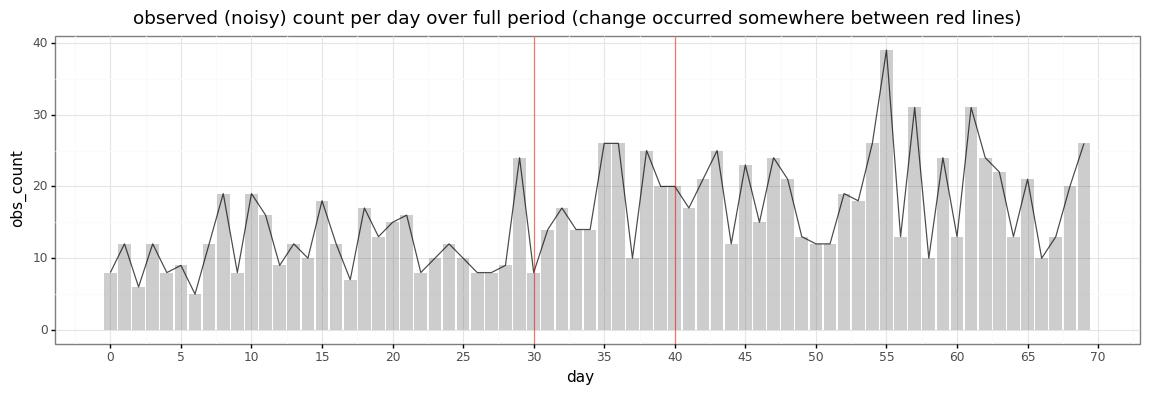

In [12]:
# Redo the plot as though we do not know any of the parameters
p = (ggplot(df_rawdata, aes(x='day', y='obs_count')) +
     geom_col(alpha=0.3) +
     geom_line(colour='black', alpha=0.7) +
     geom_vline(xintercept=stable_period, alpha=0.5, color='red') +
     geom_vline(xintercept=stable_period + change_window, alpha=0.5, color='red') +
     scale_x_continuous(breaks=np.arange(0, total_days+1, 5)) +
     labs(title="observed (noisy) count per day over full period (change occurred somewhere between red lines) ") +
     theme(legend_position="none") +
     theme(figure_size=(14, 4)))
p.draw();

# 2.0 Prepare to Model
## 2.1 Context
+ Consider as inpection data - say defects per panel. Data captured daily where first day is day 0
+ Data captures daily number of defects data - consider this as single shift data say low volume dayshift - last panel taken off line and inspected for number of defects where defect defined i.t.o. max size threshold - so say <30 defects where each defect < 2mm and specified direct distance between defects > d.
+ Change in process occurred off-shift one day bewteen day 30 and day 49 inclusive

In [13]:
df_rawdata

,day,obs_count
0,0,8
1,1,12
2,2,6
3,3,12
4,4,8
...,...,...
65,65,21
66,66,10
67,67,13
68,68,20


In [14]:
## 2.1 What distributions could model the data?
before_df = df_rawdata.copy().iloc[0:30]
after_df = df_rawdata.copy().iloc[41:]
before_df.describe()

,day,obs_count
count,30.000000,30.000000
mean,14.500000,11.733333
std,8.803408,4.502362
min,0.000000,5.000000
25%,7.250000,8.000000
50%,14.500000,11.000000
75%,21.750000,14.500000
max,29.000000,24.000000


In [15]:
k_before = np.linspace(0, df_rawdata['obs_count'].max() + 1, df_rawdata['obs_count'].max() + 2)
theory_pmf = stats.poisson.pmf(k_before, before_df['obs_count'].mean())
before_theory_df = pd.DataFrame({'k': k_before, 'proba': theory_pmf})
before_theory_df.head()

,k,proba
0,0.0,0.000008
1,1.0,0.000094
2,2.0,0.000552
3,3.0,0.002160
4,4.0,0.006335


In [16]:
k_after = np.linspace(0, df_rawdata['obs_count'].max() + 1, df_rawdata['obs_count'].max() + 2)
theory_pmf = stats.poisson.pmf(k_after, after_df['obs_count'].mean())
after_theory_df = pd.DataFrame({'k': k_after, 'proba': theory_pmf})
after_theory_df.head()

,k,proba
0,0.0,3.117586e-09
1,1.0,6.106168e-08
2,2.0,5.979834e-07
3,3.0,3.904075e-06
4,4.0,1.911651e-05


## 2.2 Compare Theoretical Poisson distribution to Observed Data 

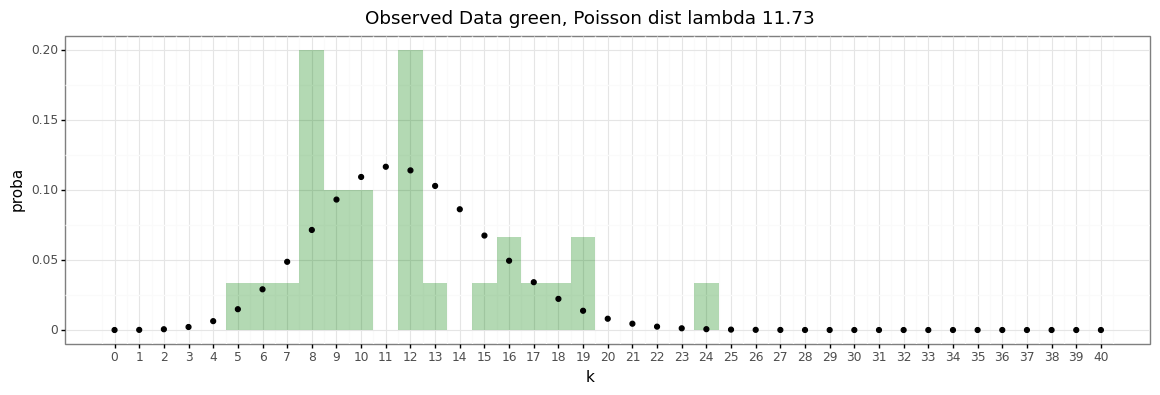

In [17]:
# Start with poisson purely because count data
p = (ggplot(before_theory_df, aes(x='k', y='proba')) +
     geom_histogram(before_df, aes('obs_count', '..density..'), binwidth=1, alpha=0.3, fill='green') +
     geom_point() + 
     scale_x_continuous(breaks=np.linspace(0, df_rawdata['obs_count'].max() + 1, df_rawdata['obs_count'].max() + 2)) +
     coord_cartesian(xlim=(0, df_rawdata['obs_count'].max() + 1)) + 
     labs(title=f"Observed Data green, Poisson dist lambda {round(before_df['obs_count'].mean(),2)}") +
     theme(figure_size=(14, 4))
    )
p.draw();

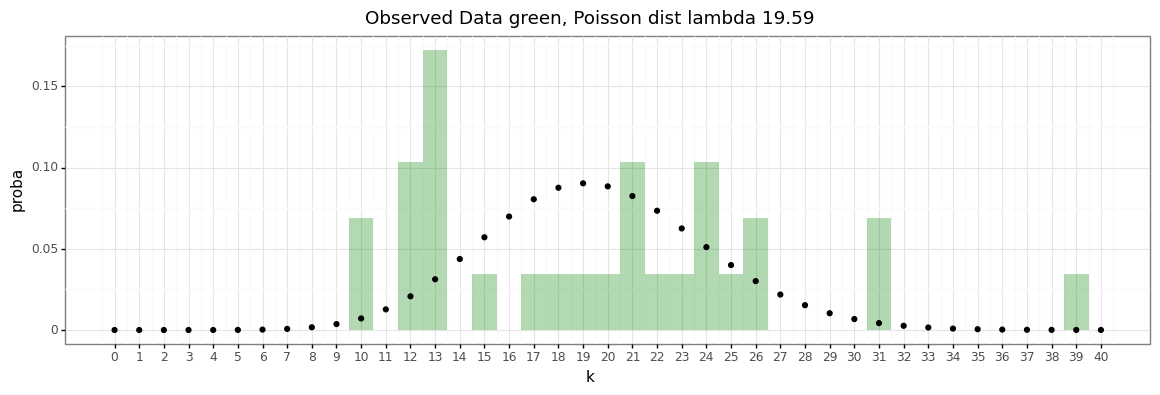

In [18]:
# Start with poisson purely because count data
p = (ggplot(after_theory_df, aes(x='k', y='proba')) +
     geom_histogram(after_df, aes('obs_count', '..density..'), binwidth=1, alpha=0.3, fill='green') +
     geom_point() + 
     scale_x_continuous(breaks=np.linspace(0, df_rawdata['obs_count'].max() + 1, df_rawdata['obs_count'].max() + 2)) +
     coord_cartesian(xlim=(0, df_rawdata['obs_count'].max() + 1)) + 
     labs(title=f"Observed Data green, Poisson dist lambda {round(after_df['obs_count'].mean(),2)}") +
     theme(figure_size=(14, 4))
    )
p.draw();

## 2.3 Make Point Estimates

In [19]:
before_theory_df.iloc[15:25]

,k,proba
15,15.0,0.067468
16,16.0,0.049477
17,17.0,0.034149
18,18.0,0.022260
19,19.0,0.013746
20,20.0,0.008065
21,21.0,0.004506
22,22.0,0.002403
23,23.0,0.001226
24,24.0,0.000599


In [20]:
## Point Estimates
lambda_1 = before_df['obs_count'].mean()
lambda_2 = after_df['obs_count'].mean()
# Thoretical distribution for before at 
change_day = 35
print(f'lambda_1: {round(lambda_1, 2)}')
print(f'lambda_2: {round(lambda_2, 2)}')
print(f'change_daya: {change_day}')

lambda_1: 11.73
lambda_2: 19.59
change_daya: 35


# 3.0 Model

## 3.1 Setup Model

In [21]:
# 2 versions to run - one with lambda priors as exponential dists, other with lambda priors as normal dists
with pm.Model() as model:
    
    
    # Prior distributions
    # ALTERNATIVE PRIORS NEXT 3 LINES
    # alpha = 1.0/df_rawdata['obs_count'].mean() # The mean count per day across the full dataset
    # lambda_1 = pm.Exponential("lambda_1", alpha)
    # lambda_2 = pm.Exponential("lambda_2", alpha)

    # Eyeballing the data, a typical day produces maybe 15 text messages, with lowest about 5, and highest say at 40
    # So, maybe can swap out exponential prior for normal mean =15, sd = (25 - 5)/6 = 20/6 ~ 3.5
    # But this is not trying to capture the distribution of the data,
    # it is trying to capture the distribution of the lambda parameters so make sd = 2
    # This works, but if sigma goes too high eg at 5.5, pymc chokes - probably because negative values in prior don't make sense
    # Complains with "ValueError: Domain error in arguments."
    # Obviously, this may choke again if the seed is changed so we get lambdas closer to 0
    # ALTERNATIVE PRIORS NEXT 4 LINES 
    mu = 15
    sigma = 2.0
    lambda_1 = pm.Normal("lambda_1", mu, sigma)
    lambda_2 = pm.Normal("lambda_2", mu, sigma)

    # Constrain prior on tau to be the change window
    tau = pm.DiscreteUniform("tau", lower=stable_period, upper=stable_period + change_window)
    
    # Function?
    idx = np.arange(total_days) # Index
    # From docs - if cond then ift else iff - ?? What does this mean? If cond true, then do first else do second?
    # docs seem a bit scant for a novice to interpret
    # Don't get this - if this was right then surely cond would be tau < idx 
    # The only way I can read this is as - If tau > switch index then lambda 2 else lambda 1
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
    # pm.Poisson - This is the only place I see poisson
    # Is this saying that the observed data should be modeled using a poisson distribution?
    # observation = pm.Poisson("obs", lambda_, observed=df_samples['count'].values)
    observation = pm.Poisson("obs_count", lambda_, observed=df_rawdata['obs_count'].values)
    

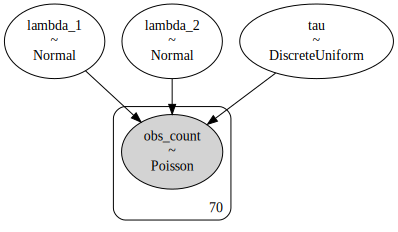

In [22]:
pm.model_to_graphviz(model)

## 3.2 Review Distributions of priors

In [23]:
# ALTERNATIVE PRIOR - EXPONENTIAL
# alpha = 1.0/df_rawdata['obs_count'].mean()
# print(alpha)

In [24]:
# ALTERNATIVE PRIOR - EXPONENTIAL
# mn = 0.000 ; mx = 1.5
# x = np.linspace(mn, mx, 3001)
# expon_df = pd.DataFrame({'z': x, 'pdf at z': stats.expon.pdf(x, scale=alpha)})
# expon_df.head()

In [25]:
# ALTERNATIVE PRIOR - EXPONENTIAL
# p = (ggplot(expon_df, aes(x='z', y='pdf at z')) +
#      geom_line(alpha=0.75) +
#      geom_vline(aes(xintercept=alpha), color='red') +
# labs(title="Prior distribution for lambdas")
#     )
# p.draw();

In [26]:
# ALTERNATIVE PRIOR - NORMAL
mn = mu ; sd = sigma
x = np.linspace(4, 26, 3001)
normal_df = pd.DataFrame({'z': x, 'pdf at z': stats.norm.pdf(x, loc=mn, scale=sd)})
normal_df.head()

,z,pdf at z
0,4.000000,5.384880e-08
1,4.007333,5.494541e-08
2,4.014667,5.606359e-08
3,4.022000,5.720376e-08
4,4.029333,5.836633e-08


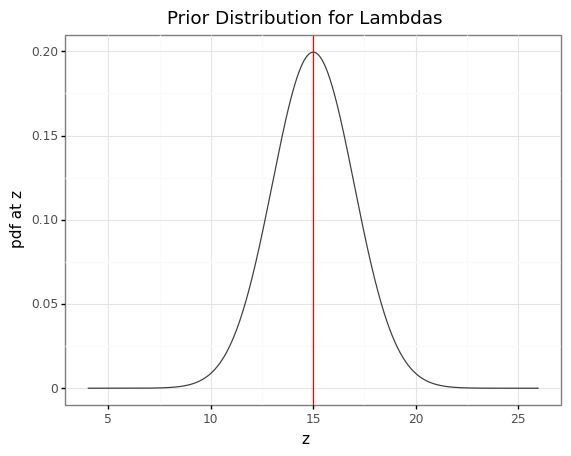

In [27]:
# ALTERNATIVE PRIOR - NORMAL
p = (ggplot(normal_df, aes(x='z', y='pdf at z')) +
     geom_line(alpha=0.75) +
     geom_vline(aes(xintercept=15), color='red') +
     labs(title="Prior Distribution for Lambdas")
    )
p.draw();

In [28]:
i_vals = range(stable_period, stable_period + change_window)
tau_df = pd.DataFrame({'i': i_vals, 'pmf at i': stats.randint.pmf(i_vals, 0, total_days)})
tau_df

,i,pmf at i
0,30,0.014286
1,31,0.014286
2,32,0.014286
3,33,0.014286
4,34,0.014286
5,35,0.014286
6,36,0.014286
7,37,0.014286
8,38,0.014286
9,39,0.014286


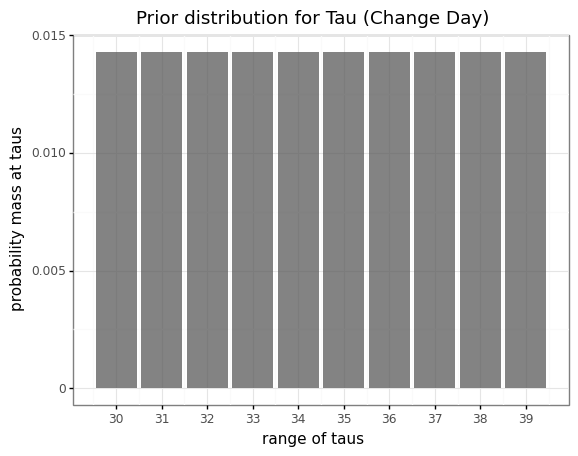

In [29]:
# Uniform pmf
p = (ggplot(tau_df, aes(x='i', y='pmf at i')) +
     geom_col(alpha=0.75) +
     xlab('range of taus') +
     ylab('probability mass at taus') +
     scale_x_continuous(breaks=np.linspace(30, 40, 11)) +
     labs(title="Prior distribution for Tau (Change Day)")
    )
p.draw();

## 3.3 Prior Predictive Model
+ Model before observed data is introduced - is model correct term?

In [30]:
help(pm.sample_prior_predictive)

Help on function sample_prior_predictive in module pymc3.sampling:

sample_prior_predictive(samples=500, model: Optional[pymc3.model.Model] = None, var_names: Optional[Iterable[str]] = None, random_seed=None) -> Dict[str, numpy.ndarray]
    Generate samples from the prior predictive distribution.
    
    Parameters
    ----------
    samples : int
        Number of samples from the prior predictive to generate. Defaults to 500.
    model : Model (optional if in ``with`` context)
    var_names : Iterable[str]
        A list of names of variables for which to compute the posterior predictive
        samples. Defaults to both observed and unobserved RVs.
    random_seed : int
        Seed for the random number generator.
    
    Returns
    -------
    dict
        Dictionary with variable names as keys. The values are numpy arrays of prior
        samples.



In [31]:
with model:
    prior = pm.sample_prior_predictive(1000)

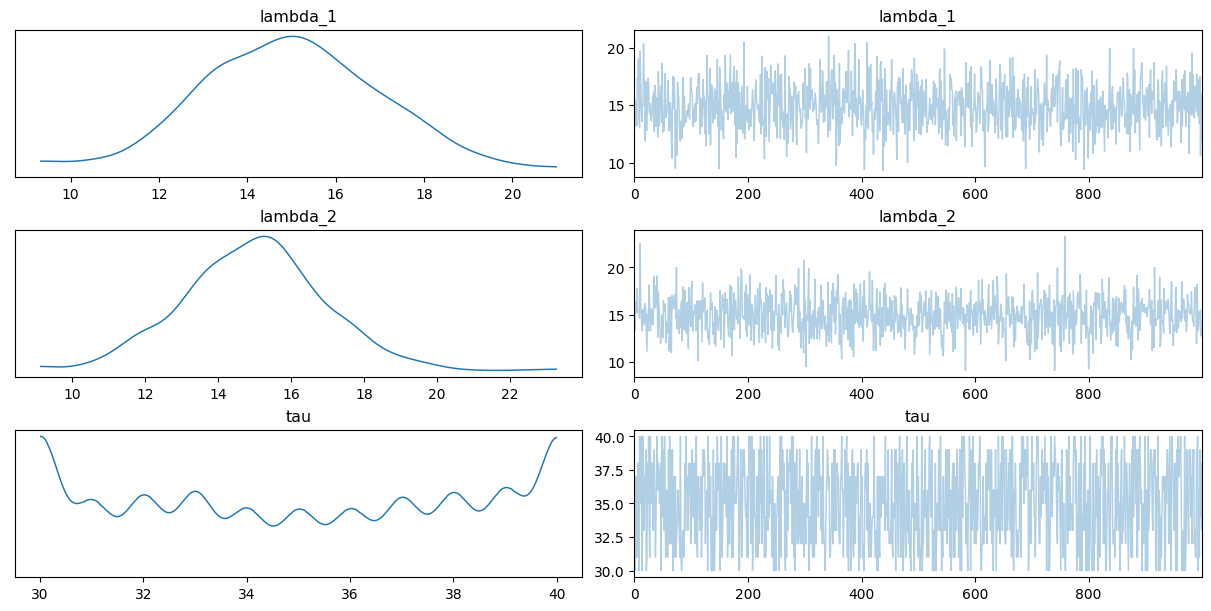

In [32]:
# This warns loudly about stats/density_utils.py:606: UserWarning: Something failed: `x` does not contain any finite number.
# I think this code is used to plot the densities, so not sure why this is complaining, but it does produce 3 plots
# of the priors.

# Hiding warnings for readability
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pm.plot_trace(prior, ['lambda_1', 'lambda_2', 'tau'])
    plt.show()

In [33]:
az.summary(prior, kind="stats", round_to=2)

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/base.py:169: UserWarning: More chains (1000) than draws (70). Passed array should have shape (chains, draws, *shape)


,mean,sd,hdi_3%,hdi_97%
lambda_1,NaN,NaN,9.31,NaN
lambda_2,NaN,NaN,9.12,NaN
tau,NaN,NaN,30.00,NaN
obs_count,NaN,NaN,1.00,NaN


In [34]:
# This shows the prior predictive distributions before any data is fitted
# So it seems that many priors could get us to this point
# However, this prior predictive data may be clearer if it made use of the switch function to plot the means
# So, for better clarity, this could be plotted on the time axis, but it means expanding the prior data to give it a day index
# so it can be plotted as 500 time series
priorpred_df = pd.DataFrame({'lambda_1': prior['lambda_1'], 'lambda_2': prior['lambda_2'], 'tau': prior['tau']})
priorpred_df.head()

,lambda_1,lambda_2,tau
0,15.555642,14.793226,37
1,15.358576,13.332394,30
2,13.167637,16.414058,37
3,15.089467,15.405093,31
4,13.239031,15.177852,37


In [35]:
exp_dfs = []
for idx, row in priorpred_df.iterrows():
    days_at_1 = int(row.tau)
    days_at_2 = int(total_days - days_at_1)
    lam1 = [row.lambda_1] * days_at_1
    lam2 = [row.lambda_2] * days_at_2
    lam1.extend(lam2)
    exp_df = pd.DataFrame({'day': range(0, total_days), 'lambda': lam1, 'sample_num': idx})
    exp_dfs.append(exp_df)
priorpredexp_df = pd.concat(exp_dfs, axis=0).reset_index(drop=True)
print(len(priorpredexp_df))
priorpredexp_df.head()

70000


,day,lambda,sample_num
0,0,15.555642,0
1,1,15.555642,0
2,2,15.555642,0
3,3,15.555642,0
4,4,15.555642,0


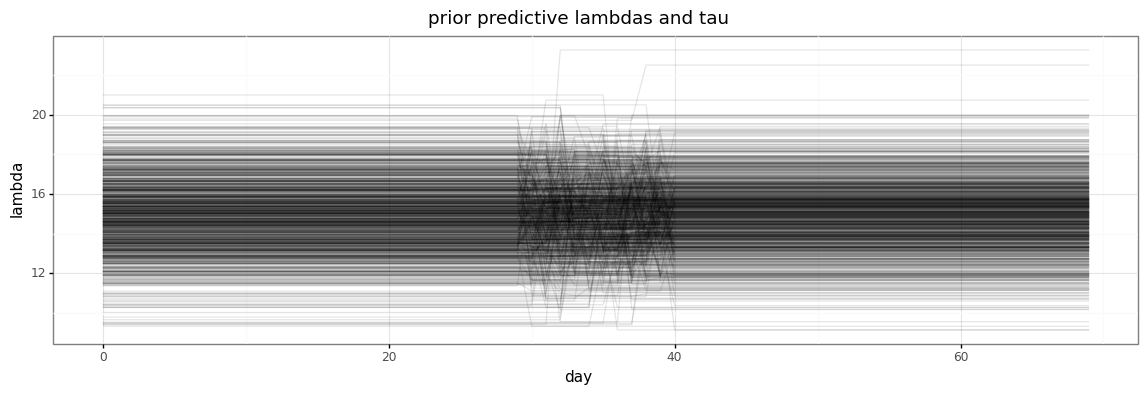

In [36]:
p = (ggplot(priorpredexp_df, aes(x='day', y='lambda', group='sample_num')) +
     geom_line(alpha=0.1) +
     labs(title="prior predictive lambdas and tau") +
     theme(figure_size=(14, 4)))
p.draw();
# This looks ok, but not good - using normal priors
# Maybe the weight of the prior should be at lower values? idk
# Next - maybe plot on top of the data to compare?,
# But that may be a bit misleading because the data is poisson distributed counts whereas the priors (lines) are poisson means

/tmp/ipykernel_44355/4099781417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


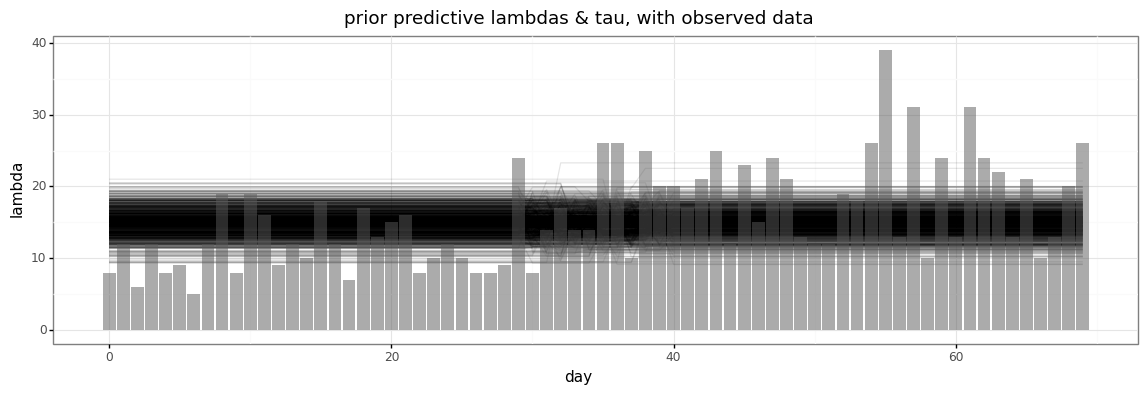

In [37]:
# Seems like have to insert this column to get plotnine to play nice with 2 datasets
df_rawdata['sample_num'] = priorpredexp_df['sample_num'].max() + 1

p = (ggplot(priorpredexp_df, aes(x='day', y='lambda', group='sample_num')) +
     geom_line(alpha=0.1) +
     geom_col(df_rawdata, aes(x='day', y='obs_count'), alpha=0.5) +  
     labs(title="prior predictive lambdas & tau, with observed data") +
     theme(figure_size=(14, 4)))
p.draw();

In [38]:
with model:
    prior_pred_data = pm.sample_prior_predictive(1000, model)['obs_count']

In [39]:
prior_pred_data_df = pd.melt(pd.DataFrame(prior_pred_data.T), var_name='sample_num', value_name='prior_pred_count')
prior_pred_data_df['day'] = list(range(0, total_days))*1000
prior_pred_data_df

,sample_num,prior_pred_count,day
0,0,16,0
1,0,14,1
2,0,11,2
3,0,10,3
4,0,20,4
...,...,...,...
69995,999,10,65
69996,999,24,66
69997,999,22,67
69998,999,20,68


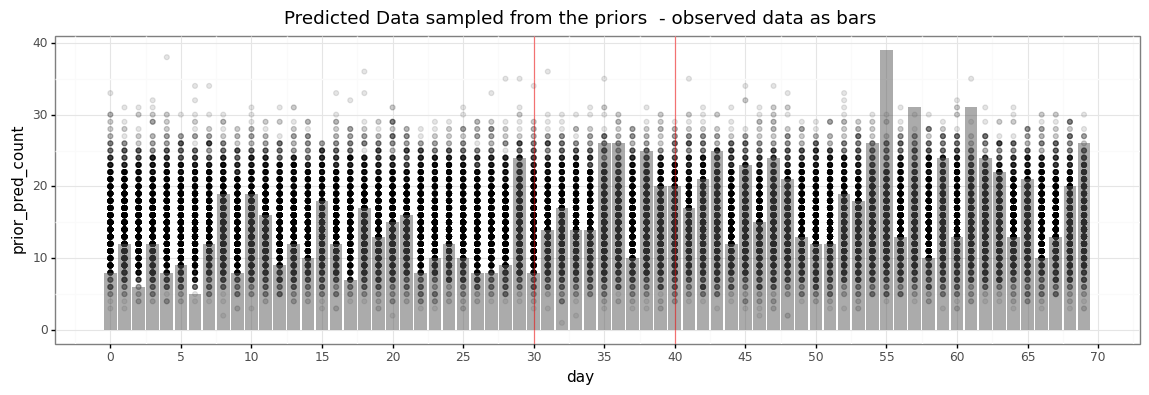

In [40]:
p = (ggplot(prior_pred_data_df,
            aes(x='day', y='prior_pred_count', group='sample_num')) +
     geom_point(alpha=0.1) +
     geom_col(df_rawdata, aes(x='day', y='obs_count'), alpha=0.5) +
     geom_vline(xintercept=stable_period, alpha=0.5, color='red') +
     geom_vline(xintercept=stable_period + change_window, alpha=0.5, color='red') +
     scale_x_continuous(breaks=np.arange(0, total_days+1, 5)) +
     labs(title="Predicted Data sampled from the priors  - observed data as bars") +
     theme(figure_size=(14, 4)))
p.draw();

<!-- ## 2.4 Fit the Data -->

## 3.4 Fit the data ? / Run algorithm to get from priors to posteriors
+ What is this step called?

In [41]:
# Sample from the posterior distributions of the fitted model
### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [42]:
help(trace)

Help on MultiTrace in module pymc3.backends.base object:

class MultiTrace(builtins.object)
 |  MultiTrace(straces)
 |  
 |  Main interface for accessing values from MCMC results.
 |  
 |  The core method to select values is `get_values`. The method
 |  to select sampler statistics is `get_sampler_stats`. Both kinds of
 |  values can also be accessed by indexing the MultiTrace object.
 |  Indexing can behave in four ways:
 |  
 |  1. Indexing with a variable or variable name (str) returns all
 |     values for that variable, combining values for all chains.
 |  
 |     >>> trace[varname]
 |  
 |     Slicing after the variable name can be used to burn and thin
 |     the samples.
 |  
 |     >>> trace[varname, 1000:]
 |  
 |     For convenience during interactive use, values can also be
 |     accessed using the variable as an attribute.
 |  
 |     >>> trace.varname
 |  
 |  2. Indexing with an integer returns a dictionary with values for
 |     each variable at the given index (corres

# 4.0 Review the model output

In [43]:
# ? what is ok/not ok?
trace.report.ok

True

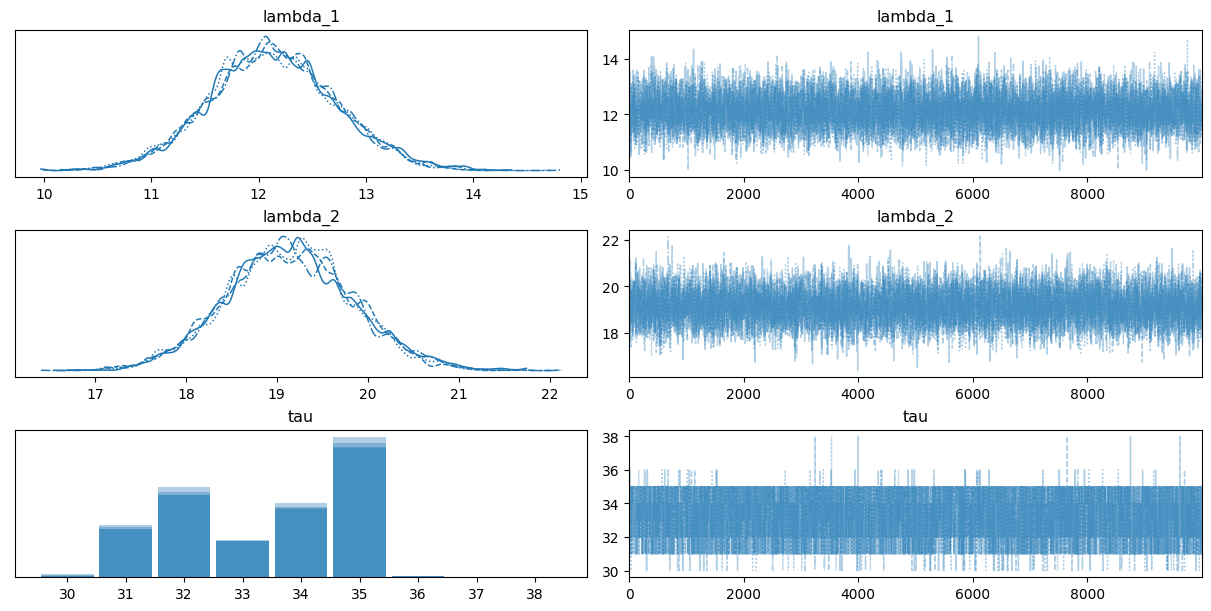

In [44]:
with model:
    pm.plot_trace(trace, ['lambda_1', 'lambda_2', 'tau'])
    plt.show()

In [45]:
# Use the same analysis code as was used for the prior predictive stuff
trace_df = pd.DataFrame({'lambda_1': trace['lambda_1'], 'lambda_2': trace['lambda_2'], 'tau': trace['tau']})
trace_df.head()

,lambda_1,lambda_2,tau
0,12.587508,19.070488,31
1,11.090948,19.070488,33
2,13.119131,19.232406,33
3,13.119131,18.760484,35
4,13.119131,20.021531,35


In [46]:
# Expand the df by making each row into a 70 day long df and concatenating on top of each other to suit plotnine
# same code as used for prior model
exp_dfs = []
for idx, row in trace_df.iterrows():
    days_at_1 = int(row.tau)
    days_at_2 = int(total_days - days_at_1)
    lam1 = [row.lambda_1] * days_at_1
    lam2 = [row.lambda_2] * days_at_2
    lam1.extend(lam2)
    exp_df = pd.DataFrame({'day': range(0, total_days), 'lambda': lam1, 'sample_num': idx})
    exp_dfs.append(exp_df)
traceexp_df = pd.concat(exp_dfs, axis=0).reset_index(drop=True)
traceexp_df.head()

,day,lambda,sample_num
0,0,12.587508,0
1,1,12.587508,0
2,2,12.587508,0
3,3,12.587508,0
4,4,12.587508,0


In [47]:
traceexp_df['sample_num'].max()

39999

In [48]:
np.random.seed(SEED)
print(len(traceexp_df))
# the expanded trace dataframe is a bit big
# To make it comparable to the prior predictive plot - cut it down to 1000 randomly chosen sample sets
samp_size = 1000
start = stats.randint.rvs(0, traceexp_df['sample_num'].max() - samp_size)
traceexpcut_df = traceexp_df[traceexp_df['sample_num'].isin(range(start, start + samp_size))]
print(len(traceexpcut_df))

2800000
70000


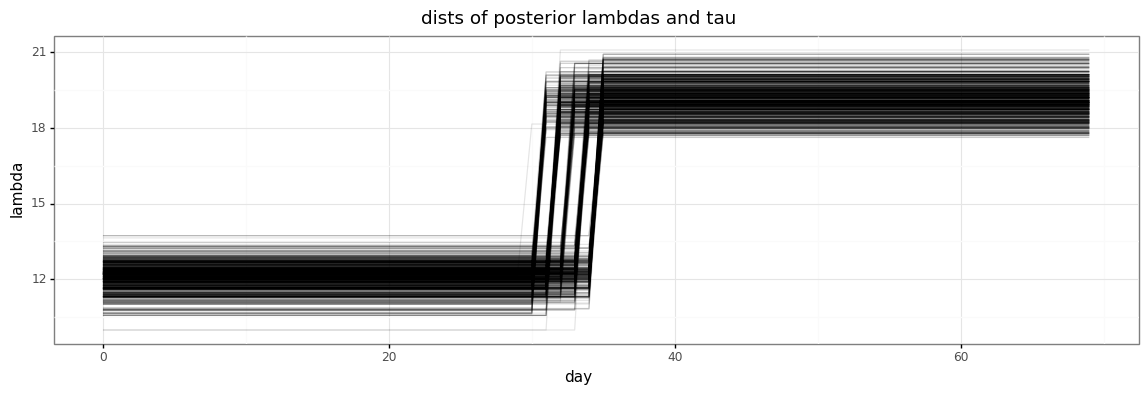

In [49]:
p = (ggplot(traceexpcut_df, aes(x='day', y='lambda', group='sample_num')) +
     geom_line(alpha=0.1) +
     labs(title="dists of posterior lambdas and tau") +
     theme(figure_size=(14, 4)))
p.draw();

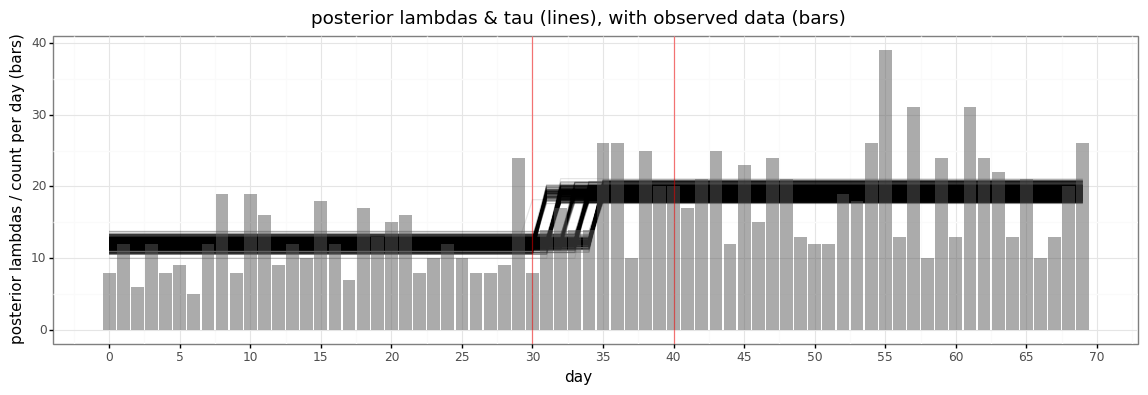

In [50]:
# Seems like have to insert this column to get plotnine to play nice with 2 datasets
# df_rawdata['sample_num'] = traceexpcut_df['sample_num'].max() + 1

p = (ggplot(traceexpcut_df, aes(x='day', y='lambda', group='sample_num')) +
     geom_line(alpha=0.1) +
     geom_col(df_rawdata, aes(x='day', y='obs_count'), alpha=0.5) +
     geom_vline(xintercept=stable_period, alpha=0.5, color='red') +
     geom_vline(xintercept=stable_period + change_window, alpha=0.5, color='red') +
     labs(title="posterior lambdas & tau (lines), with observed data (bars)") +
     ylab('posterior lambdas / count per day (bars)') +
     scale_x_continuous(breaks=np.arange(0, total_days+1, 5)) +
     theme(figure_size=(14, 4)))
p.draw();

## Predicted Data

In [51]:
with model:
    idata = pm.sample(1000, return_inferencedata=True)
    pred_data = pm.sample_posterior_predictive(idata, 1000, model)['obs_count']
pred_data

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample


array([[15,  9, 12, ..., 20, 15, 15],
       [17,  7, 11, ..., 14, 18, 17],
       [12,  8, 19, ..., 12, 22, 21],
       ...,
       [10,  8, 12, ..., 24, 21, 18],
       [15, 12, 10, ..., 17,  7, 13],
       [ 8, 13,  8, ..., 26, 22, 19]])

In [52]:
pred_data.shape

(1000, 70)

In [53]:
pred_data_df = pd.melt(pd.DataFrame(pred_data.T), var_name='sample_num', value_name='pred_obs_count')
pred_data_df['day'] = list(range(0, total_days))*1000
pred_data_df

,sample_num,pred_obs_count,day
0,0,15,0
1,0,9,1
2,0,12,2
3,0,12,3
4,0,9,4
...,...,...,...
69995,999,19,65
69996,999,17,66
69997,999,26,67
69998,999,22,68


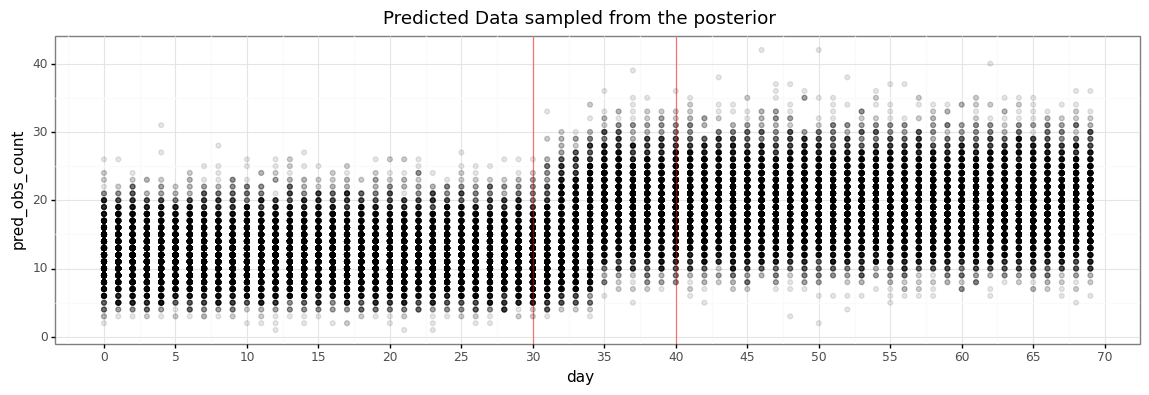

In [54]:
p = (ggplot(pred_data_df[pred_data_df['sample_num'] < 1000],
            aes(x='day', y='pred_obs_count', group='sample_num')) +
     geom_point(alpha=0.1) +
     geom_vline(xintercept=stable_period, alpha=0.5, color='red') +
     geom_vline(xintercept=stable_period + change_window, alpha=0.5, color='red') +
     scale_x_continuous(breaks=np.arange(0, total_days+1, 5)) +
     labs(title="Predicted Data sampled from the posterior") +
     theme(figure_size=(14, 4)))
p.draw();

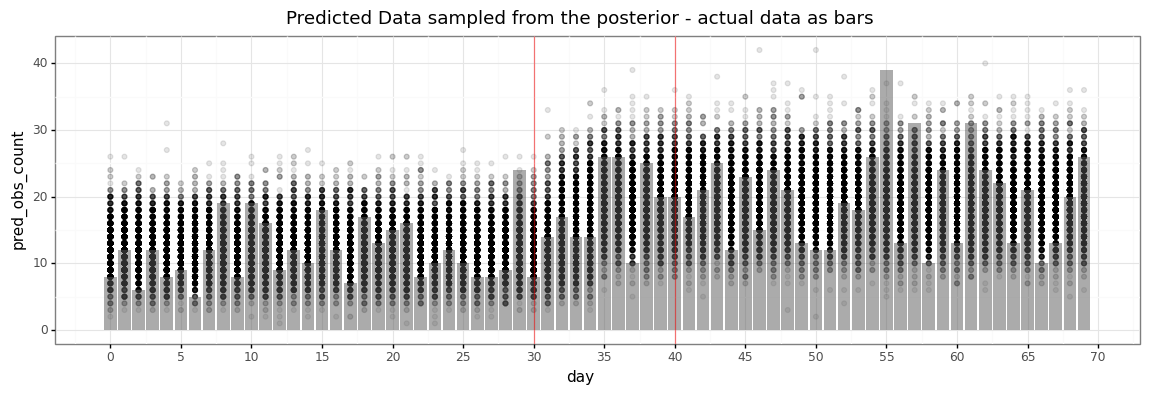

In [55]:
p = (ggplot(pred_data_df[pred_data_df['sample_num'] < 1000],
            aes(x='day', y='pred_obs_count', group='sample_num')) +
     geom_point(alpha=0.1) +
     geom_col(df_rawdata, aes(x='day', y='obs_count'), alpha=0.5) +
     geom_vline(xintercept=stable_period, alpha=0.5, color='red') +
     geom_vline(xintercept=stable_period + change_window, alpha=0.5, color='red') +
     scale_x_continuous(breaks=np.arange(0, total_days+1, 5)) +
     labs(title="Predicted Data sampled from the posterior - actual data as bars") +
     theme(figure_size=(14, 4)))
p.draw();

# 5.0 Summary

## 5.1 Underlying structure

In [56]:
np.random.seed(SEED)
lambda_1 = stats.randint.rvs(10, 18)
lambda_2 = stats.randint.rvs(15, 20)
stable_period = 30
change_window = 10
change_day = stats.randint.rvs(0, change_window)
total_days = 70

days_at_1 = stable_period + change_day
days_at_2 = total_days - (stable_period + change_day)

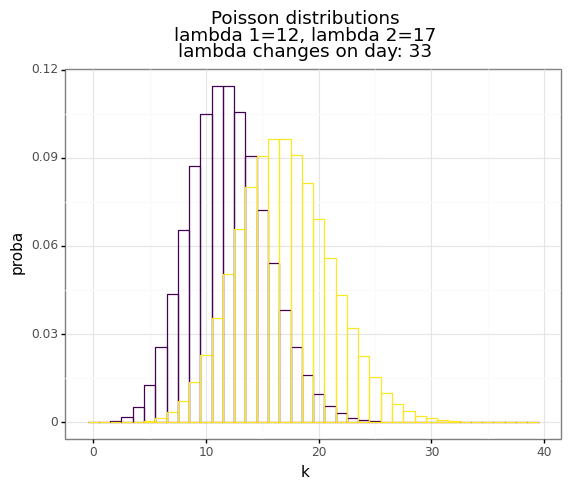

In [57]:
p = (ggplot(df_dists, aes(x='k', y='proba', colour='lambda_id')) +
     geom_col(position='dodge', alpha=0.5, width=1.0, fill="none") +
     theme(legend_position="none") +
     labs(title=f"Poisson distributions\nlambda 1={lambda_1}, lambda 2={lambda_2}\nlambda changes on day: {days_at_1}")
    )
p.draw();

## 5.2 Clean data

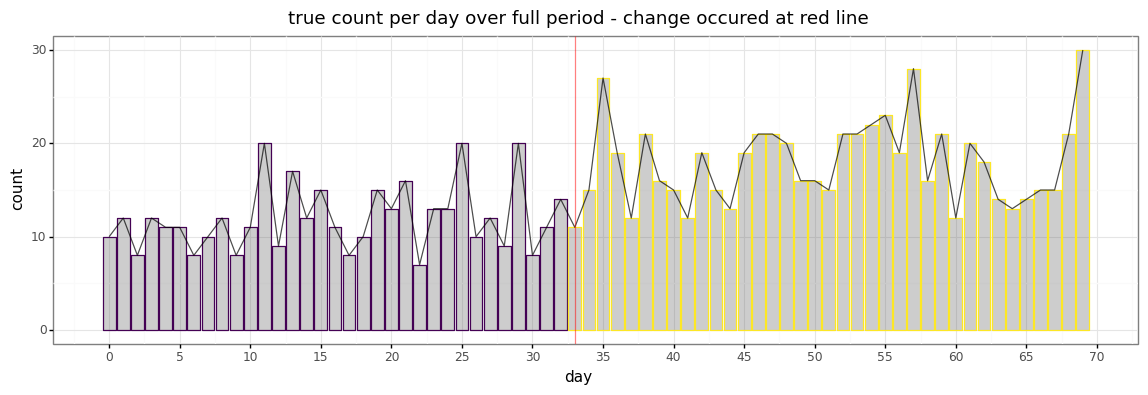

In [58]:
p = (ggplot(df_samples, aes(x='day', y='count', colour='lambda_id')) +
     geom_col(alpha=0.3) +
     geom_line(colour='black', alpha=0.7) +
     geom_vline(xintercept=stable_period + change_day, alpha=0.5, color='red') +
     scale_x_continuous(breaks=np.arange(0, total_days+1, 5)) +
     labs(title="true count per day over full period - change occured at red line") +
     theme(legend_position="none") +
     theme(figure_size=(14, 4)))
p.draw();

## 5.3 Noisy Data

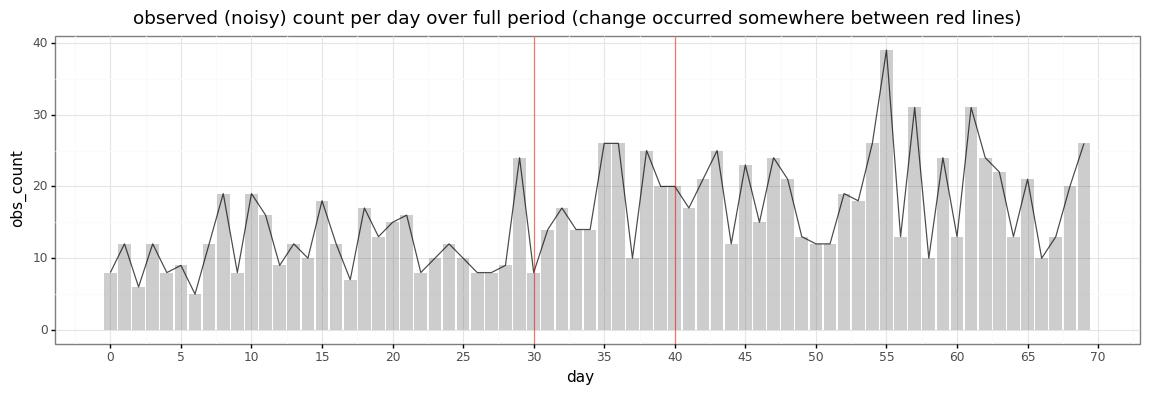

In [59]:
# Redo the plot as though we do not know any of the parameters
p = (ggplot(df_rawdata, aes(x='day', y='obs_count')) +
     geom_col(alpha=0.3) +
     geom_line(colour='black', alpha=0.7) +
     geom_vline(xintercept=stable_period, alpha=0.5, color='red') +
     geom_vline(xintercept=stable_period + change_window, alpha=0.5, color='red') +
     scale_x_continuous(breaks=np.arange(0, total_days+1, 5)) +
     labs(title="observed (noisy) count per day over full period (change occurred somewhere between red lines) ") +
     theme(legend_position="none") +
     theme(figure_size=(14, 4)))
p.draw();

## 5.4 Point Estimates

In [60]:
## Point Estimates
lambda_1 = before_df['obs_count'].mean()
lambda_2 = after_df['obs_count'].mean()
# Thoretical distribution for before at 
change_day = 35
print(f'lambda_1: {round(lambda_1, 2)}')
print(f'lambda_2: {round(lambda_2, 2)}')
print(f'change_day: {change_day}')

lambda_1: 11.73
lambda_2: 19.59
change_day: 35


## 5.5 Prior Predictive

In [ ]:
# Hiding warnings for readability
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pm.plot_trace(prior, ['lambda_1', 'lambda_2', 'tau'])
    plt.show()

In [ ]:
p = (ggplot(priorpredexp_df, aes(x='day', y='lambda', group='sample_num')) +
     geom_line(alpha=0.1) +
     geom_col(df_rawdata, aes(x='day', y='obs_count'), alpha=0.5) +  
     geom_vline(xintercept=stable_period, alpha=0.5, color='red') +
     geom_vline(xintercept=stable_period + change_window, alpha=0.5, color='red') +
     labs(title="prior predictive lambdas & tau, with observed data") +
     scale_x_continuous(breaks=np.arange(0, total_days+1, 5)) +
     theme(figure_size=(14, 4)))
p.draw();

In [ ]:
p = (ggplot(prior_pred_data_df,
            aes(x='day', y='prior_pred_count', group='sample_num')) +
     geom_point(alpha=0.1) +
     geom_col(df_rawdata, aes(x='day', y='obs_count'), alpha=0.5) +
     geom_vline(xintercept=stable_period, alpha=0.5, color='red') +
     geom_vline(xintercept=stable_period + change_window, alpha=0.5, color='red') +
     scale_x_continuous(breaks=np.arange(0, total_days+1, 5)) +
     labs(title="Predicted Data sampled from the priors  - observed data as bars") +
     theme(figure_size=(14, 4)))
p.draw();

## 5.6 Posterior (Predictive?)

In [ ]:
p = (ggplot(traceexpcut_df, aes(x='day', y='lambda', group='sample_num')) +
     geom_line(alpha=0.1) +
     geom_col(df_rawdata, aes(x='day', y='obs_count'), alpha=0.5) +
     geom_vline(xintercept=stable_period, alpha=0.5, color='red') +
     geom_vline(xintercept=stable_period + change_window, alpha=0.5, color='red') +
     labs(title="posterior lambdas & tau (lines), with observed data (bars)") +
     ylab('posterior lambdas / count per day (bars)') +
     scale_x_continuous(breaks=np.arange(0, total_days+1, 5)) +
     theme(figure_size=(14, 4)))
p.draw();

In [ ]:
with model:
    pm.plot_trace(trace, ['lambda_1', 'lambda_2', 'tau'])
    plt.show()

## 5.7 Predicted Data

In [ ]:
p = (ggplot(pred_data_df[pred_data_df['sample_num'] < 1000],
            aes(x='day', y='pred_obs_count', group='sample_num')) +
     geom_point(alpha=0.1) +
     geom_col(df_rawdata, aes(x='day', y='obs_count'), alpha=0.5) +
     geom_vline(xintercept=stable_period, alpha=0.5, color='red') +
     geom_vline(xintercept=stable_period + change_window, alpha=0.5, color='red') +
     scale_x_continuous(breaks=np.arange(0, total_days+1, 5)) +
     labs(title="Predicted Data sampled from the posterior - actual data as bars") +
     theme(figure_size=(14, 4)))
p.draw();